# Visualize the different participation loss functions that have been used

This notebook should simply help to understand how the different loss definition for participation of neurons differ. Note, that participation is hard to phrase as loss, as it depends on the history of trials.

In [1]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

### Used sigmoid

Here, we simply show how the sigmoid has to behave, when used in the loss defined below. At value 0, the sigmoid must evaluate to the desired participation level c. The sigmoid should additionally be shaped, such that derivations from the optimal trace lead to the two attractors 0 and 1 (neuron should be inactive or active if trace not optimal).

<IPython.core.display.Javascript object>


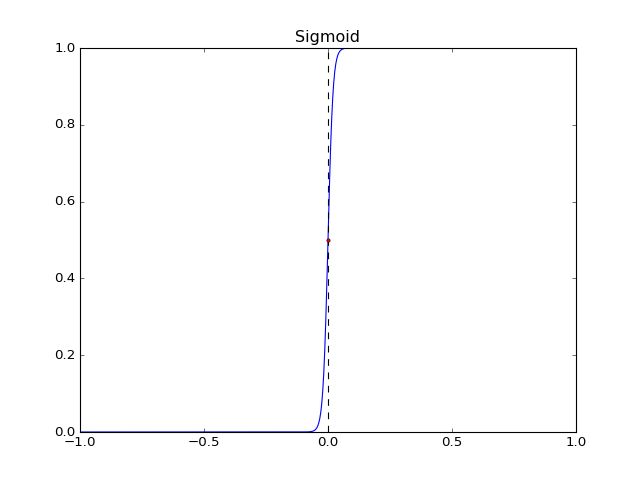

interactive(children=(FloatSlider(value=100.0, description='k', max=110.0, min=0.01), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=0.5, description='c', max=0.99, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

In [2]:
K = 100
C = 0.5

shift = lambda k, c : 1/k * np.log((1-c)/c)
sigmoid = lambda x, s, k : 1/(1+np.exp(-k * (x-s)))

x = np.linspace(-1, 1, 1000)

fig = plt.figure()
plt.title('Sigmoid')
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, sigmoid(x, shift(K, C), K))
plt.axvline(x=0, linestyle='dashed', color='k')
point, = ax.plot([0], [C], marker='o', markersize=3, color="red")

def update_k(k = 100):
    global K
    K = k
    line.set_ydata(sigmoid(x, shift(K, C), K))
    fig.canvas.draw()
    
def update_c(c = 0.5):
    global C
    C=c
    line.set_ydata(sigmoid(x, shift(K, C), K))
    point.set_ydata([C])
    fig.canvas.draw()

interact(update_k, k=(0.01,110, 0.1));
interact(update_c, c=(0.01,0.99, 0.01));

### A simple participation loss

The simple loss definition here allows the trace to be maintained outside of the scope of backprop. I.e., the loss is defined as

(gamma * trace(t-1) + (1-gamma) * x - c)^2

where trace(t-1) is an external input to the neural network (thus a constant for backprop).

This loss definition has the severe drawback, that the optimum (minima) is heavily instable (jumping around). So optimization of this loss might be quite difficult.

<IPython.core.display.Javascript object>


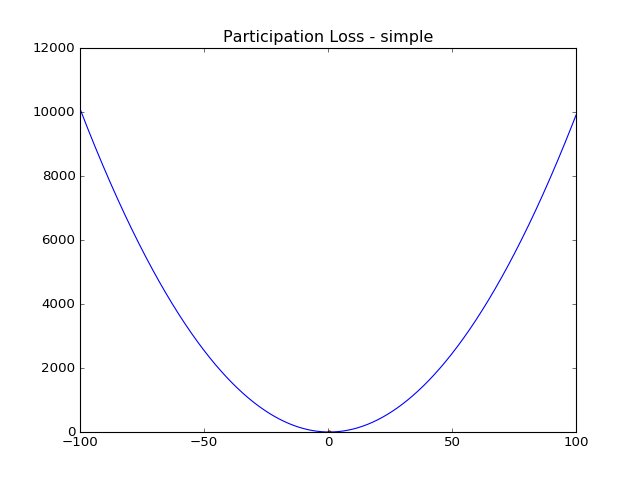

interactive(children=(FloatSlider(value=0.5, description='t', max=0.99, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=0.5, description='c', max=0.99, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

In [3]:
T2 = 0.5 # trace
C2 = 0.5 # desired activity level  
g = 0.99 # gamma fpr exp. smoothing
lr = 10000 # learning rate lambda

loss = lambda x, c , t: lr * (g*t + (1-g)*x - c)**2

x2 = np.linspace(-100, 100, 1000)

fig2 = plt.figure()
plt.title('Participation Loss - simple')
ax2 = fig2.add_subplot(1, 1, 1)
line2, = ax2.plot(x2, loss(x2, C2, T2))
# root
root = lambda c, t: -1/(1-g)*(g*t - c)
point2, = ax2.plot([root(C2, T2)], [0], marker='o', markersize=3, color="red")

def update_ts(t = 0.5):
    global T2
    T2 = t
    line2.set_ydata(loss(x2, C2, T2))
    point2.set_xdata([root(C2, T2)])
    fig2.canvas.draw()
    
def update_cs(c = 0.5):
    global C2
    C2=c
    line2.set_ydata(loss(x2, C2, T2))
    point2.set_xdata([root(C2, T2)])
    fig2.canvas.draw()

interact(update_ts, t=(0.01,0.99, 0.01));
interact(update_cs, c=(0.01,0.99, 0.01));

### Loss with clear attractors.

This loss has two clear attractor, if the trace is non optimal (which are 0 and 1). Note, that when translated to binomial neurons, neurons can only have the values 0 or 1. Therefore, this loss definition is helpful to stabilize the optimization process and additionally to get a binary behavior of neurons.

<IPython.core.display.Javascript object>


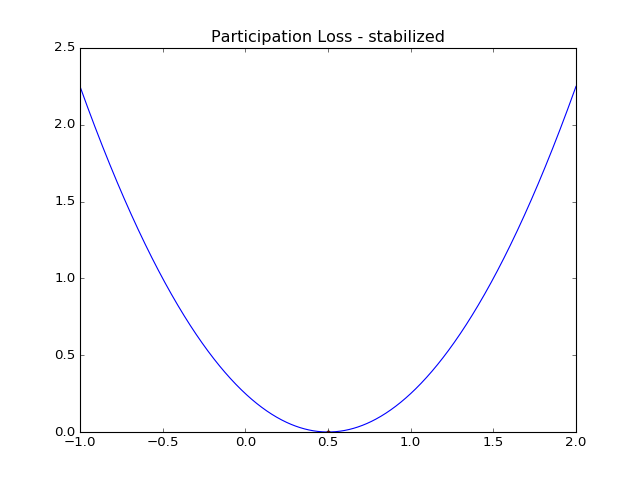

interactive(children=(FloatSlider(value=0.5, description='t', max=0.99, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=0.5, description='c', max=0.99, min=0.01, step=0.01), Output()), _dom_classes=('widget-interact',))

In [4]:
T3 = 0.5 # trace
C3 = 0.5 # desired activity level 
g3 = 0.99 # gamma fpr exp. smoothing
lr3 = 10000 # learning rate lambda

root_old = lambda c, t: -1/(1-g3)*(g3*t - c)

loss_f = lambda x, c , t: lr3 * (g3*t + (1-g3)*x - c + (1-g3)*(root_old(c,t)-sigmoid(c-t,shift(100.,c),100.)))**2

x3 = np.linspace(-1, 2, 1000)

fig3 = plt.figure()
plt.title('Participation Loss - stabilized')
ax3 = fig3.add_subplot(1, 1, 1)
line3, = ax3.plot(x3, loss_f(x3, C3, T3))
# root
root_new = lambda c, t: -1/(1-g3)*(g3*t - c + (1-g3)*(root_old(c,t)-sigmoid(c-t,shift(100.,c),100.)))
point3, = ax3.plot([root_new(C3, T3)], [0], marker='o', markersize=3, color="red")

def update_tf(t = 0.5):
    global T3
    T3 = t
    line3.set_ydata(loss_f(x3, C3, T3))
    point3.set_xdata([root_new(C3, T3)])
    fig3.canvas.draw()
    
def update_cf(c = 0.5):
    global C3
    C3=c
    line3.set_ydata(loss_f(x3, C3, T3))
    point3.set_xdata([root_new(C3, T3)])
    fig3.canvas.draw()

interact(update_tf, t=(0.01,0.99, 0.01));
interact(update_cf, c=(0.01,0.99, 0.01));

In [5]:
# Here, we nicely see, that the loss wouldn't be convex anymore, as soon as we replace the last trace value with
# the current trace value inside the sigmoid. However, for small gamma values it has almost no influence.

delete_quotation_marks = """
T3 = 0.5 # trace
C3 = 0.5 # desired activity level 
g3 = 0.5 # gamma fpr exp. smoothing
lr3 = 10000 # learning rate lambda

root_old = lambda c, t: -1/(1-g3)*(g3*t - c)

loss_f = lambda x, c , t: lr3 * (g3*t + (1-g3)*x - c + (1-g3)*(root_old(c,t)-sigmoid(c-(g3*t + (1-g3)*x),shift(100.,c),100.)))**2

x3 = np.linspace(-1, 2, 1000)

fig3 = plt.figure()
plt.title('Participation Loss - stabilized')
ax3 = fig3.add_subplot(1, 1, 1)
line3, = ax3.plot(x3, loss_f(x3, C3, T3))

def update_tf(t = 0.5):
    global T3
    T3 = t
    line3.set_ydata(loss_f(x3, C3, T3))
    fig3.canvas.draw()
    
def update_cf(c = 0.5):
    global C3
    C3=c
    line3.set_ydata(loss_f(x3, C3, T3))
    fig3.canvas.draw()

interact(update_tf, t=(0.01,0.99, 0.01));
interact(update_cf, c=(0.01,0.99, 0.01));
"""